In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

from tqdm.notebook import tqdm
tqdm.pandas()
from geoid.censusnames import stusab
import rowgenerators as rg
from geoid.acs import Puma
from pathlib import Path

from demosearch import FileCache


%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()
cache = FileCache(Path(pkg.path).parent.joinpath('data', 'cache'))

pkg

# Tract Income Distributions
`civicknowledge.com-income_dist-tract-1.2.2` Last Update: 2021-04-02T16:31:01

_Estimated portions of households per tracts in income ranges_




 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [tract_income_dist](notebooks/Extract.ipynb#tract_income_dist)**. Full tract income distribution estimates
* ** [income_quartiles](notebooks/Extract.ipynb#income_quartiles)**. Estimated portions of households per tracts in quartile ranges
* ** [census](notebooks/Extract.ipynb#census)**. Census variables for income

## References
<ul><li> <strong>pums</string>, <em>pums:{st}/h/2019/5</em>. PUMS template</li><li> <strong>puma_tract_map</string>, <em>data/puma_tract_map.csv</em>. Puma to tract map</li><li> <strong>us_tracts</string>, <em>metapack+http://library.metatab.org/civicknowledge.com-geohash-us.csv#us_tracts</em>. US Tracts, with tract numbers</li><li> <strong>households</string>, <em>census://2019/5/US/tract/B11001</em>. US Households by tract</li><li> <strong>median_income</string>, <em>census://2019/5/US/tract/B19013</em>. US Household median income by tract</li><li> <strong>agg_by_quintile</string>, <em>census://2019/5/US/tract/B19082</em>. Shares of Aggregate Household Income by Quintile</li><li> <strong>agg_hh_income</string>, <em>census://2019/5/US/tract/B19025</em>. Aggregate Household Income</li><li> <strong>agg_income</string>, <em>census://2019/5/US/tract/B19313</em>. Aggregate  Income</li><ul>

In [3]:
ptm = pkg.reference('puma_tract_map').dataframe()
ptm = ptm.rename(columns={'tract':'geoid','puma':'PUMA'})

In [4]:
%%time

k = 'pums'

if cache.exists(k):
    pums = cache.get(k)
    
else:
    frames = [rg.dataframe(pkg.reference('pums').url.format(st=st), low_memory=False) for st in tqdm(list(stusab.values()))]
    pums = pd.concat(frames)
    pums = pums[['ST','PUMA','HINCP', 'WGTP']]
    pums['PUMA'] = pums.progress_apply(lambda r: str(Puma(r.ST, r.PUMA)), axis=1)
    cache.put(k, pums)

CPU times: user 737 ms, sys: 489 ms, total: 1.23 s
Wall time: 1.3 s


In [5]:
%%time
cf = {
    'households':'hh',
    'median_income':'mi',
    'agg_by_quintile':'abq',
    'agg_income':'ai',
    'agg_hh_income':'ahhi',
    
}
census = {}


for resource_name, file_name in cf.items():

    if  not cache.exists(file_name):
        print("Loading ", resource_name)
        df = pkg.reference(resource_name).dataframe() 
        
        # Must convert from CensusDataFrame to DatFrame to avoid:
        # TypeError: can't pickle _thread.RLock objects
        cache.put_df(file_name, pd.DataFrame(df.reset_index()))
        df = cache.get_df(file_name)
            
    else:
        print("Reading ", resource_name)
        df = cache.get_df(file_name)
        
    census[resource_name] = df

mi = census['median_income']
hh = census['households']
agg = census['agg_income']
agg_hh = census['agg_hh_income']
abq = census['agg_by_quintile']


Reading  households
Reading  median_income
Reading  agg_by_quintile
Reading  agg_income
Reading  agg_hh_income
CPU times: user 195 ms, sys: 81.3 ms, total: 277 ms
Wall time: 290 ms


In [6]:
col_map = {
 'b11001_001': 'households',
 'b19013_001': 'median_income',
 'b19313_001': 'agg_income',
 'b19025_001': 'agg_hh_income',
 'b19082_001': 'hhinc_00',
 'b19082_002': 'hhinc_20',
 'b19082_003': 'hhinc_40',
 'b19082_004': 'hhinc_60',
 'b19082_005': 'hhinc_80',
 'b19082_006': 'hhinc_95'

}

t = hh.merge(mi, on='geoid').merge(agg, on='geoid').merge(agg_hh, on='geoid').merge(abq, on='geoid')

census = t[ ['geoid']+list(col_map.keys())].rename(columns=col_map)



In [7]:
# Convert the percentages of total income that each quantile has to the
# income in that quantile. 
quant_cols = [c for c in census if c.startswith('hhinc')]
for c in quant_cols:
    census[c] = pd.to_numeric(census[c])
census.loc[:,quant_cols] = (census.loc[:,quant_cols]/100).multiply(census.agg_hh_income, axis=0)

In [8]:
# This may not be the correct weighting -- maybe
# The weights are only vild within the PUMA?
samp = pums.dropna()
samp = samp.sample(int(10e6), replace=True, weights=samp.WGTP)

In [9]:
step = 5_000

# Clip so we don't deal with crazy extremes
samp['HINCP'] = samp.HINCP.clip(-step, 500_000)

# Quantize the median incomes of each puma. This becomes the index we will use
# to match tracts to PUMA distributions
samp['medinc'] = samp.groupby('PUMA').HINCP.transform(lambda g: (g.median()/step).round()*step).astype(int)
samp.head()

,ST,PUMA,HINCP,WGTP,medinc
67783,42,79500US4200702,14800.0,22,60000
85789,12,79500US1200901,21300.0,34,50000
22287,39,79500US3905505,2000.0,22,55000
124183,4,79500US0400129,22000.0,12,85000
7611,5,79500US0500500,88000.0,11,40000


In [10]:
# Build the list of bin boundaries
inc_bins = np.arange(-step, samp.HINCP.max()+step, step)

# Assign the household incomes to bins
samp['inc_bin'] = pd.cut(samp.HINCP, inc_bins).apply(lambda e: e.left)
samp.head()

,ST,PUMA,HINCP,WGTP,medinc,inc_bin
67783,42,79500US4200702,14800.0,22,60000,10000.0
85789,12,79500US1200901,21300.0,34,50000,20000.0
22287,39,79500US3905505,2000.0,22,55000,0.0
124183,4,79500US0400129,22000.0,12,85000,20000.0
7611,5,79500US0500500,88000.0,11,40000,85000.0


In [11]:
# Group by the median income index ( and across pums ) and count up the number of people

medinc_bins = samp.groupby('medinc').inc_bin.value_counts().unstack().fillna(0)
medinc_bins = medinc_bins.divide(samp.groupby('medinc').inc_bin.count(), axis=0)
medinc_bins.columns = list(medinc_bins.columns)
medinc_bins.sort_index(level=['medinc', ]).head(10)

,-5000.0,0.0,5000.0,10000.0,15000.0,20000.0,25000.0,30000.0,35000.0,40000.0,...,450000.0,455000.0,460000.0,465000.0,470000.0,475000.0,480000.0,485000.0,490000.0,495000.0
medinc,,,,,,,,,,,,,,,,,,,,,
15000,0.087831,0.107895,0.156819,0.139196,0.107129,0.079403,0.064618,0.050201,0.041404,0.028889,...,0.000000,0.000000,0.000000,0.000000,0.000114,0.000028,0.000000,0.000000,0.000000,0.000057
20000,0.067647,0.091759,0.125998,0.123309,0.104230,0.084294,0.065673,0.055405,0.048139,0.036898,...,0.000029,0.000000,0.000000,0.000057,0.000057,0.000000,0.000000,0.000029,0.000000,0.000229
25000,0.044305,0.059637,0.116484,0.111312,0.090544,0.077005,0.064605,0.057153,0.054933,0.043063,...,0.000061,0.000000,0.000020,0.000102,0.000122,0.000163,0.000000,0.000000,0.000000,0.000916
30000,0.038411,0.043178,0.098755,0.093894,0.084891,0.072832,0.067704,0.055493,0.053157,0.043409,...,0.000189,0.000042,0.000121,0.000147,0.000094,0.000152,0.000131,0.000063,0.000079,0.001848
35000,0.030041,0.034708,0.075161,0.084812,0.078979,0.071929,0.066557,0.057132,0.056436,0.046311,...,0.000150,0.000153,0.000116,0.000113,0.000101,0.000098,0.000079,0.000073,0.000122,0.001674
40000,0.022438,0.028483,0.057649,0.073675,0.070806,0.068580,0.065481,0.057506,0.057733,0.047970,...,0.000134,0.000151,0.000171,0.000143,0.000196,0.000177,0.000099,0.000152,0.000140,0.002316
45000,0.018027,0.025347,0.046713,0.063506,0.064210,0.063285,0.062057,0.055171,0.056712,0.048691,...,0.000192,0.000185,0.000224,0.000240,0.000193,0.000226,0.000204,0.000123,0.000185,0.003100
50000,0.014917,0.022152,0.039451,0.054684,0.055992,0.057383,0.057085,0.052762,0.054269,0.047001,...,0.000224,0.000213,0.000230,0.000257,0.000162,0.000242,0.000211,0.000180,0.000169,0.003662
55000,0.013165,0.019193,0.033314,0.047060,0.050680,0.051538,0.052773,0.048204,0.051939,0.045204,...,0.000268,0.000222,0.000299,0.000271,0.000257,0.000319,0.000246,0.000225,0.000192,0.004598


In [12]:

mi_max = max(medinc_bins.index)
mi_min = min(medinc_bins.index)

In [13]:
census['medinc'] = (census.median_income/step).clip(mi_min, mi_max).round().fillna(0).astype(int)
census.head()

,geoid,households,median_income,agg_income,agg_hh_income,hhinc_00,hhinc_20,hhinc_40,hhinc_60,hhinc_80,hhinc_95,medinc
0,14000US01001020100,709,60208.0,62231000,58707900,1702529.1,4091940.63,8471549.97,13491075.42,30956675.67,13256243.82,15000
1,14000US01001020200,688,43958.0,40718100,36164700,1348943.31,3149945.37,6025039.02,9203916.15,16436856.15,5265580.32,15000
2,14000US01001020300,1360,55345.0,86089300,82071900,3373155.09,8338505.04,14280510.6,20091201.12,35988528.15,11514687.57,15000
3,14000US01001020400,1675,59663.0,125932600,123080000,6363236.0,14264972.0,19988192.0,29403812.0,53059788.0,20172812.0,15000
4,14000US01001020500,4483,66108.0,414151800,403905900,12924988.8,41319573.57,62645805.09,88980469.77,198035062.77,108933421.23,15000


In [14]:
t = census.reset_index().merge(medinc_bins.reset_index(), on='medinc')

t.loc[:,-5000:]= t.loc[:,-5000:].multiply(t.households, axis=0)

tracts = pkg.reference('us_tracts').dataframe()
tracts = tracts[['geoid','tract_id']]
tract_income_dist = tracts.merge(t)#.drop(columns=['medinc','households'])
tract_income_dist = tract_income_dist.rename(columns={ c:str(int(c//1000))+'k' for c in tract_income_dist.loc[:,-5000:].columns })
tract_income_dist.head()

,geoid,tract_id,index,households,median_income,agg_income,agg_hh_income,hhinc_00,hhinc_20,hhinc_40,...,450k,455k,460k,465k,470k,475k,480k,485k,490k,495k
0,14000US01055010700,0,318,1376,46078.0,81490500,79543200,4422601.92,8948610.0,12901907.04,...,0.0,0.0,0.0,0.0,0.156195,0.039049,0.0,0.0,0.0,0.078098
1,14000US01055001300,1,306,1092,22946.0,42149100,35495200,1508546.0,3247810.8,4976427.04,...,0.0,0.0,0.0,0.0,0.123957,0.030989,0.0,0.0,0.0,0.061979
2,14000US01055000900,2,302,898,30238.0,43570000,34296100,1755960.32,3549646.35,5219866.42,...,0.0,0.0,0.0,0.0,0.101935,0.025484,0.0,0.0,0.0,0.050968
3,14000US01055001700,3,308,684,24462.0,29897100,25409600,1384823.2,2492681.76,3402345.44,...,0.0,0.0,0.0,0.0,0.077643,0.019411,0.0,0.0,0.0,0.038822
4,14000US01055010501,4,314,3200,73248.0,294057000,277982800,11897663.84,29215992.28,46728908.68,...,0.0,0.0,0.0,0.0,0.363244,0.090811,0.0,0.0,0.0,0.181622


In [15]:
income_ranges = tract_income_dist[['geoid']].copy()
income_ranges['lt25k'] = tract_income_dist.loc[:,'-5k':'20k'].sum(axis=1)
income_ranges['25k_50k'] = tract_income_dist.loc[:,'25k':'45k'].sum(axis=1)
income_ranges['50k_75k'] = tract_income_dist.loc[:,'50k':'70k'].sum(axis=1)
income_ranges['75k_120k'] = tract_income_dist.loc[:,'75k':'115k'].sum(axis=1)
income_ranges['gt120k'] = tract_income_dist.loc[:,'120k':].sum(axis=1)
income_ranges['gt50k'] = tract_income_dist.loc[:,'50k':].sum(axis=1)
income_ranges['gt60k'] = tract_income_dist.loc[:,'60k':].sum(axis=1)
income_quartiles = income_ranges
income_quartiles.describe()


,lt25k,25k_50k,50k_75k,75k_120k,gt120k,gt50k,gt60k
count,72913.000000,72913.000000,72913.000000,72913.000000,72913.000000,72913.000000,72913.000000
mean,1134.291974,354.558192,110.766808,48.834210,23.871339,183.472356,124.719439
std,553.474098,173.005522,54.048305,23.828494,11.647942,89.524742,60.856447
min,8.139281,2.544185,0.794824,0.350417,0.171292,1.316533,0.894943
25%,760.344543,237.669306,74.249787,32.734803,16.001561,122.986151,83.602588
50%,1055.393496,329.896021,103.062149,45.437426,22.210909,170.710483,116.044270
75%,1410.130513,440.780095,137.703218,60.709774,29.676400,228.089392,155.048868
max,14385.501703,4496.635422,1404.784778,619.333135,302.744963,2326.862875,1581.737102


In [20]:
census

,geoid,households,median_income,agg_income,agg_hh_income,hhinc_00,hhinc_20,hhinc_40,hhinc_60,hhinc_80,hhinc_95,medinc
0,14000US01001020100,709,60208.0,62231000,58707900,1702529.1,4091940.63,8471549.97,13491075.42,30956675.67,13256243.82,15000
1,14000US01001020200,688,43958.0,40718100,36164700,1348943.31,3149945.37,6025039.02,9203916.15,16436856.15,5265580.32,15000
2,14000US01001020300,1360,55345.0,86089300,82071900,3373155.09,8338505.04,14280510.6,20091201.12,35988528.15,11514687.57,15000
3,14000US01001020400,1675,59663.0,125932600,123080000,6363236.0,14264972.0,19988192.0,29403812.0,53059788.0,20172812.0,15000
4,14000US01001020500,4483,66108.0,414151800,403905900,12924988.8,41319573.57,62645805.09,88980469.77,198035062.77,108933421.23,15000
...,...,...,...,...,...,...,...,...,...,...,...,...
73996,14000US72153750501,1565,20221.0,52305900,40307100,471593.07,3583301.19,6150863.46,10048560.03,20052782.25,6840114.87,15000
73997,14000US72153750502,762,18871.0,30083000,25263000,287998.2,1551148.2,3071980.8,5830700.4,14521172.4,5355756.0,15000
73998,14000US72153750503,597,13699.0,19055100,13382400,107059.2,848444.16,1719638.4,3154231.68,7554364.8,2739377.28,15000
73999,14000US72153750601,1233,23722.0,40621700,35912900,1185125.7,3454820.98,5681420.78,9129059.18,16458882.07,5907672.05,15000


In [36]:
tracts = pkg.reference('us_tracts').geoframe()
t = tracts[['geoid','geometry']].merge(census)

In [38]:
cx =  -117.31,32.57,-116.8, 33.21
t = t.cx[cx[0]:cx[2], cx[1]:cx[3]]
t.to_csv('census.csv')

<AxesSubplot:>

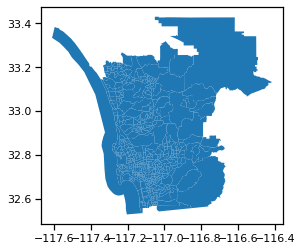